In [1]:
import fastgps 
import qmcpy as qp 
import torch 
torch.set_default_dtype(torch.float64)
import numpy as np
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.stats import norm
import itertools
import time
import pandas as pd
import matplotlib
from matplotlib import pyplot
pyplot.style.use("seaborn-v0_8-whitegrid")
COLORS = ["xkcd:"+color[:-1] for color in pd.read_csv("../../../xkcd_colors.txt",comment="#",header=None).iloc[:,0].tolist()][::-1]
pyplot.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=COLORS)
LINESTYLES = ['solid','dotted','dashed','dashdot',(0, (1, 1))]
DEFAULTFONTSIZE = 30
pyplot.rcParams['xtick.labelsize'] = DEFAULTFONTSIZE
pyplot.rcParams['ytick.labelsize'] = DEFAULTFONTSIZE
pyplot.rcParams['ytick.labelsize'] = DEFAULTFONTSIZE
pyplot.rcParams['axes.titlesize'] = DEFAULTFONTSIZE
pyplot.rcParams['figure.titlesize'] = DEFAULTFONTSIZE
pyplot.rcParams["axes.labelsize"] = DEFAULTFONTSIZE
pyplot.rcParams['legend.fontsize'] = DEFAULTFONTSIZE
pyplot.rcParams['font.size'] = DEFAULTFONTSIZE
pyplot.rcParams['lines.linewidth'] = 5
pyplot.rcParams['lines.markersize'] = 15
PW = 30 # inches

tensor(99.9225) tensor(8.0512) tensor(2.2201) tensor(110.1937)
tensor(4.0468) tensor(0.0841) tensor(0.0213) tensor(4.1522)


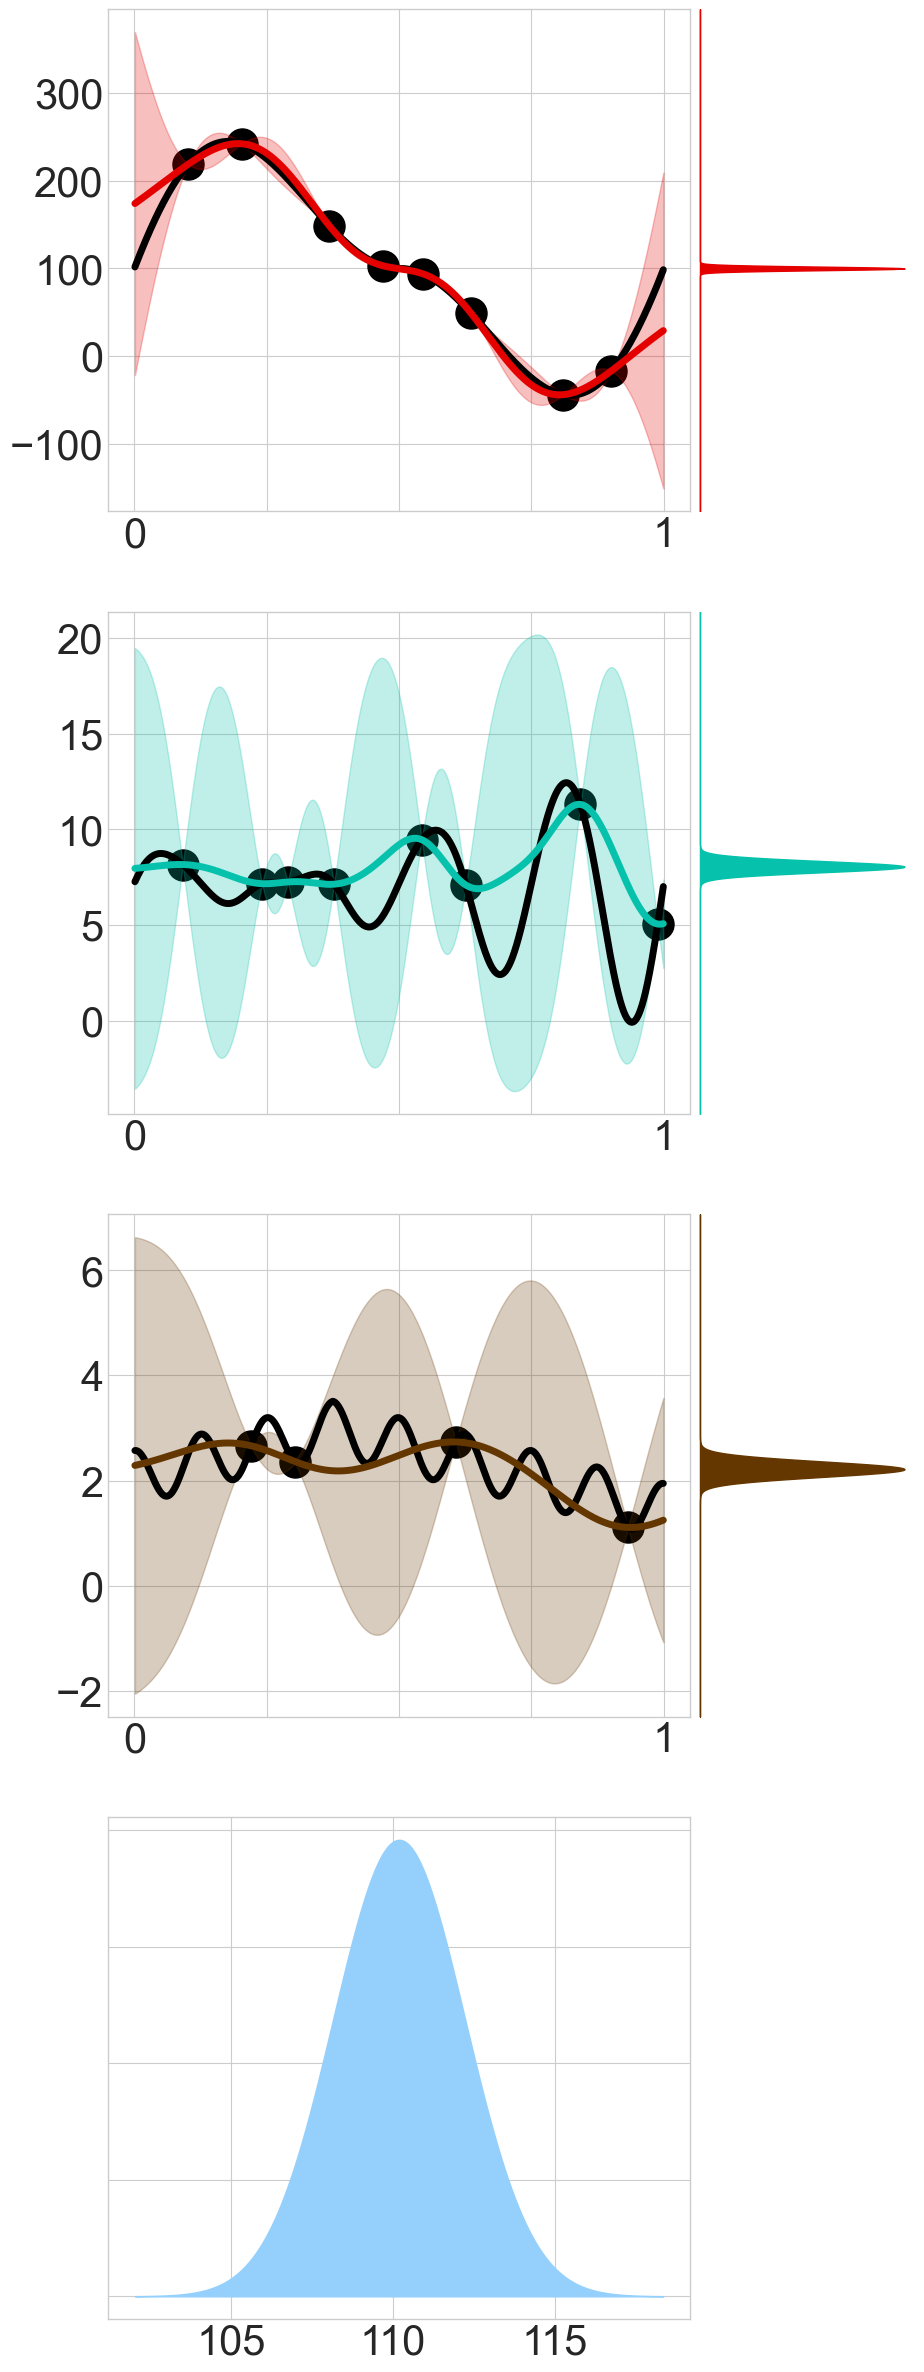

In [25]:
def diffs(l, x):
    assert x.ndim==2 and x.size(1)==1
    assert l in [0,1,2]
    x = x[:,0]
    if l==0:
        return 500*torch.abs(x-1/2)*torch.sin(2*np.pi*x)+100
    elif l==1:
        return 10*(torch.abs(x-1/4)*torch.sin(8*np.pi*x)+torch.cos(16*np.pi*x)/50)+7
    else:
        return (torch.cos(16*np.pi*x)-5*torch.abs(x-3/8)+torch.cos(16*np.pi*x)/50)/2+3
xticks = torch.linspace(0,1,1000)[1:-1]
yticks0 = diffs(0,xticks[:,None])
yticks1 = diffs(1,xticks[:,None])
yticks2 = diffs(2,xticks[:,None])
# FGP 0
fgp0 = fastgps.StandardGP(
    # kernel = qp.KernelDigShiftInvarCombined(d=1,torchify=True),
    kernel = qp.KernelSquaredExponential(d=1,torchify=True),
    # kernel = qp.KernelShiftInvar(d=1,torchify=True,alpha=1),
    seqs = qp.DigitalNet(1,seed=7),
    # seqs = qp.Lattice(1,seed=7),
)
xnext0 = fgp0.get_x_next(2**3)
ynext0 = diffs(0,xnext0)
fgp0.add_y_next(ynext0)
fgp0.fit(stop_crit_improvement_threshold=1e-2,verbose=False)
yhat0,_,_,ci_low0,ci_high0 = fgp0.post_ci(xticks[:,None])
muhat0,varhat0,_,pci_low0,pci_high0 = fgp0.post_cubature_ci()
# FGP 1
fgp1 = fastgps.StandardGP(
    # kernel = qp.KernelDigShiftInvarCombined(d=1,torchify=True),
    kernel = qp.KernelSquaredExponential(d=1,torchify=True),
    # kernel = qp.KernelShiftInvar(d=1,torchify=True,alpha=1),
    seqs = qp.DigitalNet(1,seed=13),
    # seqs = qp.Lattice(1,seed=13),
)
xnext1 = fgp1.get_x_next(2**3)
ynext1 = diffs(1,xnext1)
fgp1.add_y_next(ynext1)
fgp1.fit(stop_crit_improvement_threshold=1e-2,verbose=False)
yhat1,_,_,ci_low1,ci_high1 = fgp1.post_ci(xticks[:,None])
muhat1,varhat1,_,pci_low1,pci_high1 = fgp1.post_cubature_ci()
# FGP 2
fgp2 = fastgps.StandardGP(
    # kernel = qp.KernelDigShiftInvarCombined(d=1,torchify=True),
    kernel = qp.KernelSquaredExponential(d=1,torchify=True),
    # kernel = qp.KernelShiftInvar(d=1,torchify=True,alpha=1),
    seqs = qp.DigitalNet(1,seed=10),
    # seqs = qp.Lattice(1,seed=3),
)
xnext2 = fgp2.get_x_next(2**2)
ynext2 = diffs(2,xnext2)
fgp2.add_y_next(ynext2)
fgp2.fit(stop_crit_improvement_threshold=1e-2,verbose=False)
yhat2,_,_,ci_low2,ci_high2 = fgp2.post_ci(xticks[:,None])
muhat2,varhat2,_,pci_low2,pci_high2 = fgp2.post_cubature_ci()
fig,ax = pyplot.subplots(nrows=4,ncols=1,figsize=(PW/4,PW))
ax[0].plot(xticks,yticks0,color="k")
ax[0].scatter(xnext0[:,0],ynext0,color="k",s=500)
ax[0].plot(xticks,yhat0,color=COLORS[3])
ax[0].fill_between(xticks,ci_low0,ci_high0,alpha=.25,color=COLORS[3])
ax[1].plot(xticks,yticks1,color="k")
ax[1].scatter(xnext1[:,0],ynext1,color="k",s=500)
ax[1].plot(xticks,yhat1,color=COLORS[4])
ax[1].fill_between(xticks,ci_low1,ci_high1,alpha=.25,color=COLORS[4])
ax[2].plot(xticks,yticks2,color="k")
ax[2].scatter(xnext2[:,0],ynext2,color="k",s=500)
ax[2].plot(xticks,yhat2,color=COLORS[6])
ax[2].fill_between(xticks,ci_low2,ci_high2,alpha=.25,color=COLORS[6])
for i in range(3):
    ax[i].set_xticks([0,1/4,1/2,3/4,1])
    ax[i].set_xticklabels([0,"","","",1])
axd0 = fig.add_axes([ax[0].get_position().x1,ax[0].get_position().y0,.3,ax[0].get_position().y1-ax[0].get_position().y0])
axd0.axis(False)
y0ticks = torch.linspace(*ax[0].get_ylim(),1000)
axd0.fill_betweenx(y0ticks,0,1/torch.sqrt(2*np.pi*varhat0)*torch.exp(-(y0ticks-muhat0)**2/(2*varhat0)),color=COLORS[3])
axd0.set_ylim(*ax[0].get_ylim())
axd1 = fig.add_axes([ax[1].get_position().x1,ax[1].get_position().y0,.3,ax[1].get_position().y1-ax[1].get_position().y0])
axd1.axis(False)
y1ticks = torch.linspace(*ax[1].get_ylim(),1000)
axd1.fill_betweenx(y1ticks,0,1/torch.sqrt(2*np.pi*varhat1)*torch.exp(-(y1ticks-muhat1)**2/(2*varhat1)),color=COLORS[4])
axd1.set_ylim(*ax[1].get_ylim())
axd2 = fig.add_axes([ax[2].get_position().x1,ax[2].get_position().y0,.3,ax[2].get_position().y1-ax[2].get_position().y0])
axd2.axis(False)
y2ticks = torch.linspace(*ax[2].get_ylim(),1000)
axd2.fill_betweenx(y2ticks,0,1/torch.sqrt(2*np.pi*varhat2)*torch.exp(-(y2ticks-muhat2)**2/(2*varhat2)),color=COLORS[6])
axd2.set_ylim(*ax[2].get_ylim())
varcomb = varhat0+varhat1+varhat2
mucomb = muhat0+muhat1+muhat2
xnewticks = torch.linspace(mucomb-4*torch.sqrt(varcomb),mucomb+4*torch.sqrt(varcomb),1000)
ax[3].fill_between(xnewticks,0,1/torch.sqrt(2*np.pi*varcomb)*torch.exp(-(xnewticks-mucomb)**2/(2*varcomb)),color=COLORS[7])
ax[3].set_yticklabels([])
print(muhat0,muhat1,muhat2,mucomb)
print(varhat0,varhat1,varhat2,varcomb)
fig.savefig("visual.pdf",bbox_inches="tight",transparent=True)